<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-данных." data-toc-modified-id="Получение-данных.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение данных.</a></span></li><li><span><a href="#Предобработка-данных." data-toc-modified-id="Предобработка-данных.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных.</a></span><ul class="toc-item"><li><span><a href="#Результат-предобработки-данных." data-toc-modified-id="Результат-предобработки-данных.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Результат предобработки данных.</a></span></li></ul></li><li><span><a href="#Исследование-данных." data-toc-modified-id="Исследование-данных.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование данных.</a></span></li><li><span><a href="#Вывод-по-проекту." data-toc-modified-id="Вывод-по-проекту.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод по проекту.</a></span></li></ul></div>

# Описание проекта.

**Задание:**

**Выполнить подключение к любому API из раздела Shopping https://github.com/public-apis/public-apis#shopping  
Получить данные   
Выполнить базовый анализ данных и сделать общие выводы**

**Формат: ссылка на репозиторий гитхаб.**

# Импорт данных через api Best Buy.

В качестве источника получения данных был выбран сайт Best Buy. После изучения документации к API на сайте https://bestbuyapis.github.io/api-documentation/#overview выяснилось, что для получения токена и использования API необходимо произвести регистрацию на сайте https://www.bestbuy.com/identity/signin?token=tid%3A92d3993c-9354-11ed-9fb4-1297d60b998f. К сожалению осуществить регистрацию на сайте не удалось, ввиду того что номер телефона любой отличный от США не принимается. Можно было бы создать виртуальную sim с помощью стороних сервисов, но было принято другое решение.

# Создание собственного парсера.

Попробуем написать собственную программу для парсинга данных из раздела https://www.bestbuy.com/site/promo/laptop-and-computer-deals

## Получение данных.

Импортируем основные библиотеки для работы с парсингом.

In [1]:
import requests  # Импорт библиотеки для запросов к серверу
from bs4 import BeautifulSoup # Импорт библиотеки для автоматического парсинга странички
import csv

Создадим основные переменные куда пропишем сохраняемый csv файл, а также HOST и URL куда пропишем адрес сайта и данные с запрашиваемой страницы.

In [2]:
CSV = 'laptops.csv'
HOST = 'https://www.bestbuy.com/'
URL = 'https://www.bestbuy.com/site/promo/laptop-and-computer-deals'

Для того чтобы сайт нас не блокировал в процессе запросов, необходимо создать переменную HEADERS (заголовки) куда мы занесем данные о нашем окружении. Переменную HEADERS создаем в качестве словаря. 

In [3]:
HEADERS = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
}

Далее необходимо написать функцию get_html, которая будет принимать на себя адрес страницы в интернете и параметры. 

In [4]:
def get_html(url, params=''):
    r = requests.get(url, headers=HEADERS, params=params)
    return r

html = get_html(URL)
print(html)

<Response [200]>


Код 200 свидетельствует о том что доступ к странице получен успешно.

Далее напишем функцию get_content, которая с помощью библиотеки BeautifulSoup будем получать объект со страницы.

In [5]:
def get_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    items = soup.find_all('div', class_='app-container lv')
    laptops = []

    for item in items:
        laptops.append(
            {
                'title':item.find('div', class_='sku-title').get_text(strip=True),
                'link_product': HOST + item.find('div', class_='sku-title').find('a').get('href'),
                'product_info':item.find('div', class_='variation-info').get_text(),
                'product_image': HOST + item.find('div', class_='image-link').find('img').get(src)
            }
        )
    return laptops


def save_doc(items, path):
    with open(path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(['Название продукта', 'Ссылка на продукт', 'Информация о товаре', 'Изображение товара'])
        for item in items:
            writer.writerow( [item['title'], item['link_product'], item['product_info'], item['product_image']])
           
    

def parser():
    PAGENATION = input('Укажите количество страниц для парсинга: ')
    PAGENATION = int(PAGENATION.strip())
    html = get_html(URL)
    if html.status_code == 200:
        laptops = []
        for cp in range(1, PAGENATION):
            print(f'Парсим страницу: {cp}')
            html = get_html(URL, params={'cp': cp})
            laptops.extend(get_content(html.text))
            save_doc(laptops, CSV)
        pass
    else:
        print('Error')
        
parser()

Укажите количество страниц для парсинга: 1


Как видно из результатов работы функций, программа не возвращает нам данные. Полученный файл содержит только названия столбцов. Это свидетельствует о том, что к данному сайту получить доступ можно исключительно через API. 

Воспользуемся другим способом получения данных. Для этого воспользуемся следующим сервисом: https://blog.apify.com/how-to-scrape-best-buy-product-data/. Данный сервис представляет собой сторонее API для подключения к различным сайтам и позволяет выгрузить итоговые данные в любом удобном для нас формате. Выбираем csv файл.

## Предобработка данных.

Загрузим дополнительные библиотеки для работы с данными.

In [6]:
import numpy as np #это база
import pandas as pd
import seaborn as sns
import datetime as dt

import plotly.express as px # графики
import re #уточнить
import math as mth #уточнить

from matplotlib import pyplot as plt # графики (это база)
from IPython.display import display
from scipy import stats as st  #AB test
from plotly import graph_objects as go # строить воронки

Откроет датасет с помощью конструкции try\except.

In [7]:
try:
    data = pd.read_csv('https://api.apify.com/v2/datasets/U7uUaF1c6TSx2p6TK/items?attachment=true&clean=true&format=csv', sep=',') #конструкция try/except если датасет есть на сайте
except:
    data = pd.read_csv('/datasets/dataset_bestbuy', sep=',')

In [8]:
pd.set_option('display.max_columns', None) #добавим параметр отображать все столбцы

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Columns: 1503 entries, aggregateRating/ratingValue to width
dtypes: float64(144), int64(27), object(1332)
memory usage: 258.5+ KB


Как видно из датасета, спарсилось большое количество столбцов(1503), причем некоторые из них не несут смысловую нагрузку, необходимо почистить датасет оставив только основную информацию.

In [10]:
data.drop(data.columns[254:1498], axis = 1, inplace=True)

In [11]:
data.drop(data.columns[238:252], axis = 1, inplace=True)

In [12]:
data.drop(data.columns[158:197], axis = 1, inplace=True)

In [13]:
data.drop(data.columns[173:194], axis = 1, inplace=True)

In [14]:
data.drop(data.columns[13:78], axis = 1, inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Columns: 120 entries, aggregateRating/ratingValue to width
dtypes: float64(10), int64(4), object(106)
memory usage: 20.8+ KB


In [16]:
data.drop(data.columns[13:90], axis = 1, inplace=True)

In [17]:
data.drop(data.columns[[5,7,10,12,13,14,16,17,26,27,29,30,31,32,34,37,38,40]], axis = 1, inplace=True)

In [18]:
data.drop(data.columns[[13,19]], axis = 1, inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   aggregateRating/ratingValue  22 non-null     float64
 1   aggregateRating/reviewCount  22 non-null     int64  
 2   brand                        22 non-null     object 
 3   color/category               22 non-null     object 
 4   color/displayName            20 non-null     object 
 5   condition/type               22 non-null     object 
 6   description                  22 non-null     object 
 7   descriptions/long            22 non-null     object 
 8   features/0/description       22 non-null     object 
 9   height                       18 non-null     object 
 10  model                        22 non-null     object 
 11  modelFamily                  9 non-null      object 
 12  name                         22 non-null     object 
 13  names/display         

Остановимся на этом моменте. Итак у нас получилось 22 строки, а именно 22 модели ноутбуков. Изучим различные особенности имеющихся данных.

Проверим датасет на наличие дубликатов методом duplicated().sum()

In [20]:
data.duplicated().sum()

0

В датасете дубликаты не найдены. Воспользуемся методом isna().sum() и определим количество пропусков в каждом из столбцов датасета.

In [21]:
data.isna().sum()

aggregateRating/ratingValue     0
aggregateRating/reviewCount     0
brand                           0
color/category                  0
color/displayName               2
condition/type                  0
description                     0
descriptions/long               0
features/0/description          0
height                          4
model                           0
modelFamily                    13
name                            0
names/display                   0
names/rawShort                  0
names/short                     0
names/title                     0
offers/highPrice                5
offers/priceCurrency            0
productSeries                  14
warranties/labor                0
weight                          0
width                           2
dtype: int64

В столбцах датасета присутствуют пропущенные значения. Пропуски лучше не заполнять, так как у нас нет достоверных сведений,которые мы можем использовать. Заполнение пропусков средним или медианной могут исказить результаты исследования.

### Результат предобработки данных.

В результате предобработки данных датасет был проверен на дубликаты, пропуски. Для строк с пропусками было принято решение не заполнять их, так как заполнение средним или медианными значениями могут исказить результаты исследований. А проверенными данными мы не обладаем. Также были выборочно удалены столбцы не содержащие основную информацию о товаре.

## Исследование данных.

In [22]:
data.head()

,aggregateRating/ratingValue,aggregateRating/reviewCount,brand,color/category,color/displayName,condition/type,description,descriptions/long,features/0/description,height,model,modelFamily,name,names/display,names/rawShort,names/short,names/title,offers/highPrice,offers/priceCurrency,productSeries,warranties/labor,weight,width
0,4.5,178,ASUS,Gray,NaN,new,"Shop ASUS TUF Gaming A15 15.6"" FHD 144Hz Gamin...",ASUS TUF Gaming A15 Gaming Laptop gives you a ...,"Family, friends, passions, music, creations, g...",0.88 inches,FA507RE-A15.R73050T,NaN,"ASUS - TUF Gaming A15 15.6"" FHD 144Hz Gaming L...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...","ASUS - TUF Gaming A15 15.6"" FHD 144Hz Gaming L...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...",879.99,USD,NaN,1 year,4.85 pounds,9.88 inches
1,4.6,53,Microsoft,Green,Sage,new,Shop Microsoft Surface Laptop 5 – 13.5” Touch ...,Multitasking speed powered by 12th Gen Intel C...,"Family, friends, passions, music, creations – ...",0.57 inches,R1S-00051,"Microsoft Surface Laptop 5 13.5""",Microsoft - Surface Laptop 5 – 13.5” Touch Scr...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,Microsoft - Surface Laptop 5 – 13.5” Touch Scr...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,NaN,USD,"Surface Laptop 13""",1 year,2.87 pounds,12.1 inches
2,4.7,465,HP,Silver,Natural Silver,new,"Shop HP ENVY x360 2-in-1 15.6"" Touch-Screen La...",Your ideas deserve the best: It packs in all o...,"From a rejuvenated Start menu, to new ways to ...",0.73 inches,15-ew0013dx,NaN,"HP - ENVY x360 2-in-1 15.6"" Touch-Screen Lapto...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...","HP - ENVY x360 2-in-1 15.6"" Touch-Screen Lapto...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...",649.99,USD,NaN,1 year,3.88 pounds,14.13 inches
3,4.7,167,LG,Black,Black,new,Shop LG 27” IPS LED FHD AMD FreeSync Monitor (...,27” FHD 3-Side Virtually Borderless Design IPS...,"From sharp imagery to spot-on color, watch you...",NaN,27MQ44B-B,NaN,LG - 27” IPS LED FHD AMD FreeSync Monitor (HDM...,"27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...","27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...",LG - 27” IPS LED FHD AMD FreeSync Monitor (HDM...,"27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...",119.99,USD,NaN,1 year,8.6 pounds,24.1 inches
4,4.5,291,Samsung,Silver,Mystic Silver,new,"Shop Samsung Galaxy Book 15.6"" LED Touch Scree...","Why can’t laptops be more like phones? Thin, l...","Get the fast, reliable power you need to make ...",0.61 inches,NP750TDA-XD2US,NaN,"Samsung - Galaxy Book 15.6"" LED Touch Screen -...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...","Samsung - Galaxy Book 15.6"" LED Touch Screen -...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...",799.99,USD,NaN,1 year,3.51 pounds,9.02 inches


Столбец aggregateRating/ratingValue содержит агрегированный рейтинг присвоенный ноутбуку на основе оценок пользователей. Отобразим данный рейтинг с помощью гистограммы методом hist().

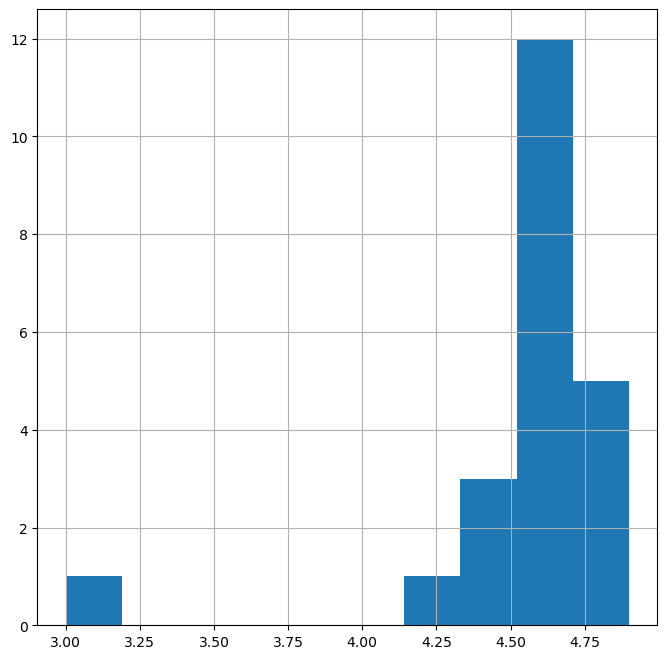

In [23]:
data['aggregateRating/ratingValue'].hist(figsize=(8, 8));

Как видно на диаграмме, большинство устройств с достаточном высоким рейтингом(от 4.5 до 4.75) Интересно что есть устройство с оценкой 3 балла. Сделаем срез данных и посмотрим что это за устройство.

In [24]:
bad_rating = data.loc[data['aggregateRating/ratingValue'] < 4].reset_index(drop=True)
bad_rating

,aggregateRating/ratingValue,aggregateRating/reviewCount,brand,color/category,color/displayName,condition/type,description,descriptions/long,features/0/description,height,model,modelFamily,name,names/display,names/rawShort,names/short,names/title,offers/highPrice,offers/priceCurrency,productSeries,warranties/labor,weight,width
0,3.0,3,Microsoft,Silver,Platinum,new,"Shop Microsoft Surface Pro 9 – 13"" Touch Scree...",Surface Pro 9 gives you the tablet flexibility...,Surface Pro 9 gives you the tablet flexibility...,0.37 inches,QCB-00001,Microsoft Surface Pro 9,"Microsoft - Surface Pro 9 – 13"" Touch Screen –...","Surface Pro 9 – 13"" Touch Screen – Intel Core ...","Surface Pro 9 – 13"" Touch Screen – Intel Core ...","Microsoft - Surface Pro 9 – 13"" Touch Screen –...","Surface Pro 9 – 13"" Touch Screen – Intel Core ...",NaN,USD,NaN,1 year,31.74 ounces,11.3 inches


Данное устройство бренда Microsoft. Возможно данному рейтингу нельзя доверять, так как значение в столбце aggregateRating/reviewCount равно 3. Это значит, что всего три пользователя поставили оценку данному устройству. Попробуем посчитать сколько пользователей оценили то или иное устройство.  

In [25]:
data_brand_rating = data.groupby('brand')['aggregateRating/reviewCount'].value_counts()
data_brand_rating

brand      aggregateRating/reviewCount
ASUS       99                             1
           178                            1
Apple      1347                           2
           411                            1
           2825                           1
Dell       321                            1
           381                            1
HP         14                             1
           214                            1
           296                            1
           465                            1
           508                            1
           865                            1
           990                            1
LG         167                            1
Microsoft  3                              1
           53                             1
Samsung    291                            1
SanDisk    8792                           1
WD         2470                           1
           12664                          1
Name: aggregateRating/reviewCount, dt

Больше всего оценок у ноутбука бренда WD.

Теперь посмотрим распределение популярности по брендам ноутбуков. Отобразим данные на гистограмме. 

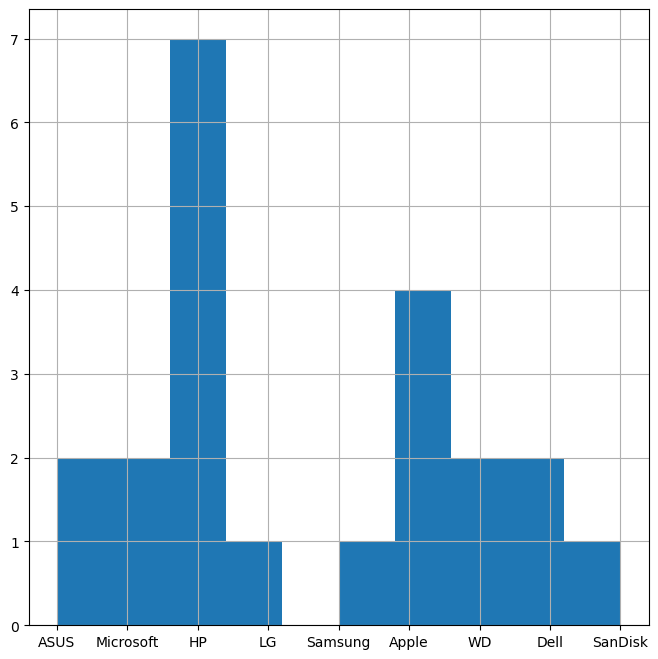

In [26]:
data['brand'].hist(figsize=(8, 8));

Можем выделить два самых популярных бренда в текущем датасете. Это HP и Apple.

In [27]:
data.head()

,aggregateRating/ratingValue,aggregateRating/reviewCount,brand,color/category,color/displayName,condition/type,description,descriptions/long,features/0/description,height,model,modelFamily,name,names/display,names/rawShort,names/short,names/title,offers/highPrice,offers/priceCurrency,productSeries,warranties/labor,weight,width
0,4.5,178,ASUS,Gray,NaN,new,"Shop ASUS TUF Gaming A15 15.6"" FHD 144Hz Gamin...",ASUS TUF Gaming A15 Gaming Laptop gives you a ...,"Family, friends, passions, music, creations, g...",0.88 inches,FA507RE-A15.R73050T,NaN,"ASUS - TUF Gaming A15 15.6"" FHD 144Hz Gaming L...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...","ASUS - TUF Gaming A15 15.6"" FHD 144Hz Gaming L...","TUF Gaming A15 15.6"" FHD 144Hz Gaming Laptop-A...",879.99,USD,NaN,1 year,4.85 pounds,9.88 inches
1,4.6,53,Microsoft,Green,Sage,new,Shop Microsoft Surface Laptop 5 – 13.5” Touch ...,Multitasking speed powered by 12th Gen Intel C...,"Family, friends, passions, music, creations – ...",0.57 inches,R1S-00051,"Microsoft Surface Laptop 5 13.5""",Microsoft - Surface Laptop 5 – 13.5” Touch Scr...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,Microsoft - Surface Laptop 5 – 13.5” Touch Scr...,Surface Laptop 5 – 13.5” Touch Screen – Intel ...,NaN,USD,"Surface Laptop 13""",1 year,2.87 pounds,12.1 inches
2,4.7,465,HP,Silver,Natural Silver,new,"Shop HP ENVY x360 2-in-1 15.6"" Touch-Screen La...",Your ideas deserve the best: It packs in all o...,"From a rejuvenated Start menu, to new ways to ...",0.73 inches,15-ew0013dx,NaN,"HP - ENVY x360 2-in-1 15.6"" Touch-Screen Lapto...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...","HP - ENVY x360 2-in-1 15.6"" Touch-Screen Lapto...","ENVY x360 2-in-1 15.6"" Touch-Screen Laptop - I...",649.99,USD,NaN,1 year,3.88 pounds,14.13 inches
3,4.7,167,LG,Black,Black,new,Shop LG 27” IPS LED FHD AMD FreeSync Monitor (...,27” FHD 3-Side Virtually Borderless Design IPS...,"From sharp imagery to spot-on color, watch you...",NaN,27MQ44B-B,NaN,LG - 27” IPS LED FHD AMD FreeSync Monitor (HDM...,"27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...","27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...",LG - 27” IPS LED FHD AMD FreeSync Monitor (HDM...,"27” IPS LED FHD AMD FreeSync Monitor (HDMI, Di...",119.99,USD,NaN,1 year,8.6 pounds,24.1 inches
4,4.5,291,Samsung,Silver,Mystic Silver,new,"Shop Samsung Galaxy Book 15.6"" LED Touch Scree...","Why can’t laptops be more like phones? Thin, l...","Get the fast, reliable power you need to make ...",0.61 inches,NP750TDA-XD2US,NaN,"Samsung - Galaxy Book 15.6"" LED Touch Screen -...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...","Samsung - Galaxy Book 15.6"" LED Touch Screen -...","Galaxy Book 15.6"" LED Touch Screen - Intel® Co...",799.99,USD,NaN,1 year,3.51 pounds,9.02 inches


Построим гистограмму для столбца color/category.

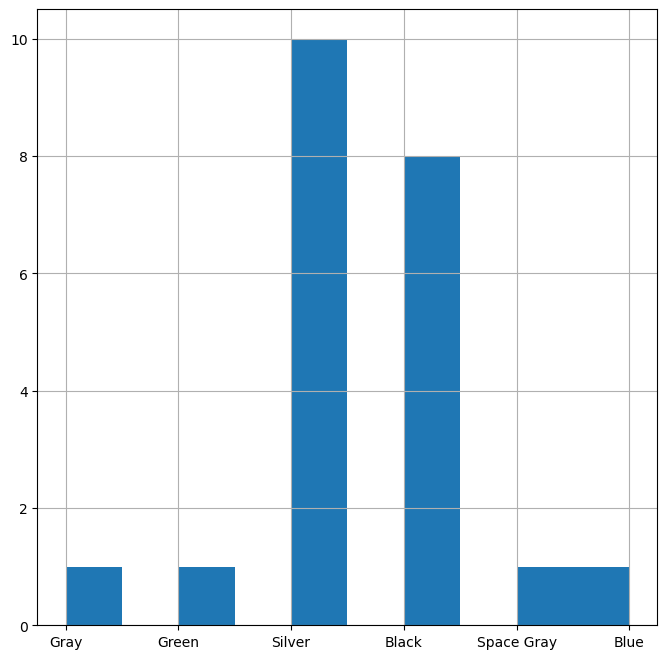

In [28]:
data['color/category'].hist(figsize=(8, 8));

Два самых популярных цвета - серебрянный и черный. Наименее популярные цвета - серый, зеленый, космический серый и синий.

Изучим столбец condition/type и посмотрим какие значения присутствуют в столбце с помощью метода unique().

In [29]:
data['condition/type'].unique()

array(['new'], dtype=object)

В данном столбце присутствует одно значение - new. Следовательно все ноутбуки из текущего набора данных являются новыми.

В столбце description присутствует достаточно длинное описание товара. На основе этих данных пользователь может больше узнать о товаре и определиться с покупкой. 

Построим гистограмму для столбца height. 

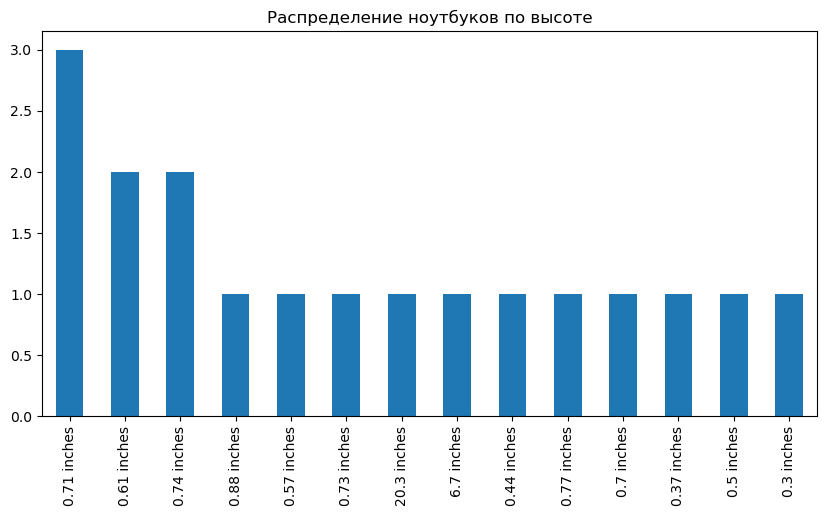

In [30]:
data['height'].value_counts().sort_values(ascending=False).plot(figsize=(10,5),kind="bar",title='Распределение ноутбуков по высоте');

Больше всего ноутбуков высотой:
1) 0.71 дюйма - 3 модели;  
2) 0.61 дюйма - 2 модели;  
3) 0.74 дюйма - 2 модели.   

Вероятно в данных также присутствуют ошибки - есть 2 ноутбука с высотой 20.3 дюйма и 6.7 дюйма. 

Построим диаграмму рассеяния для столбцов offers/highPrice и brand. Определим стоимость ноутбуков для различных брендов.

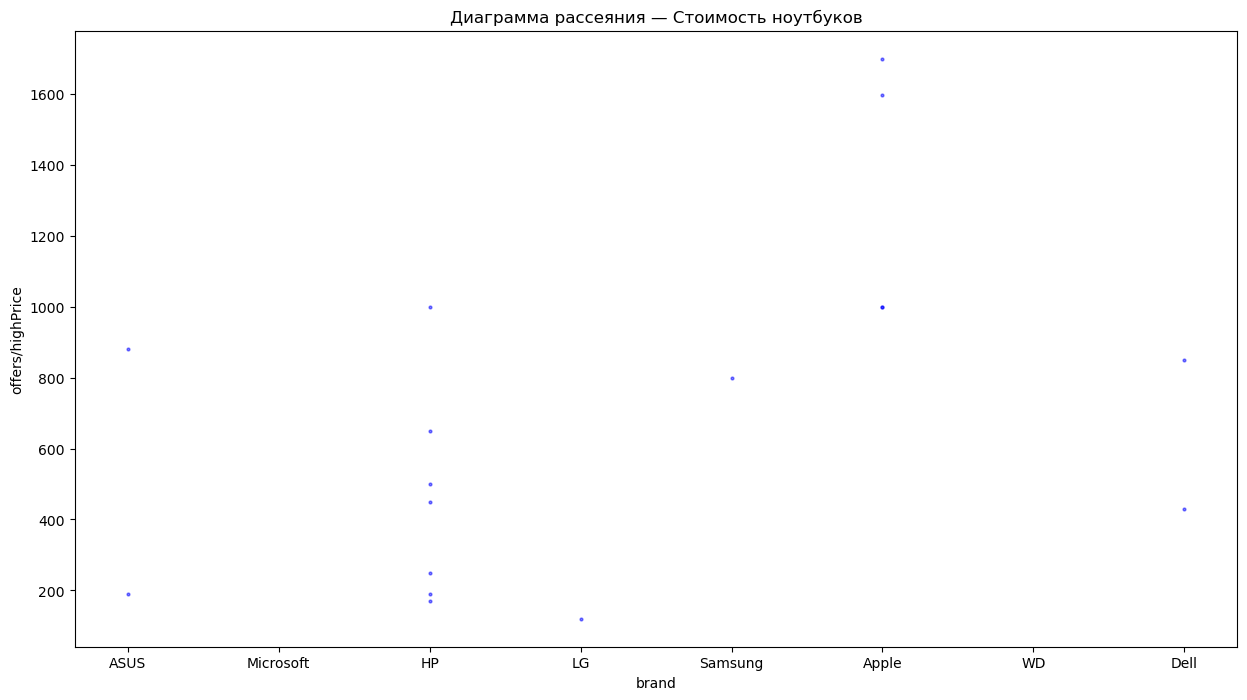

In [31]:
data.plot(kind='scatter',
        y='offers/highPrice' , x='brand', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Стоимость ноутбуков');

Как видно на диаграмме рассеяния самый дорогой бренд - это Apple (цена начинается от 1000 долларов). Два самых недорогих бренда: Asus(200 долларов) и LG(менее 200 долларов). В нашем датасете самый широкий разброс цен у бренда HP(цены варьируются от 200 до 1000).

Убедимся что стоимость товаров представлена в одной валюте - USD. Для этого воспользуемся методом unique для столбца offers/priceCurrency.

In [32]:
data['offers/priceCurrency'].unique()

array(['USD'], dtype=object)

Валюта действительно только одна - USD.

Определим какую гарантию на товар предоставляют производители. Построим диаграмму рассеяния для столбцов warranties/labor и brand.

In [33]:
data['warranties/labor'].unique()

array(['1 year', '1 year limited', '2 Years',
       '1 Year Hardware Service with Onsite/In-Home Service After Remote Diagnosis',
       '2 years', '5 years limited', '1 Year Mail In Service'],
      dtype=object)

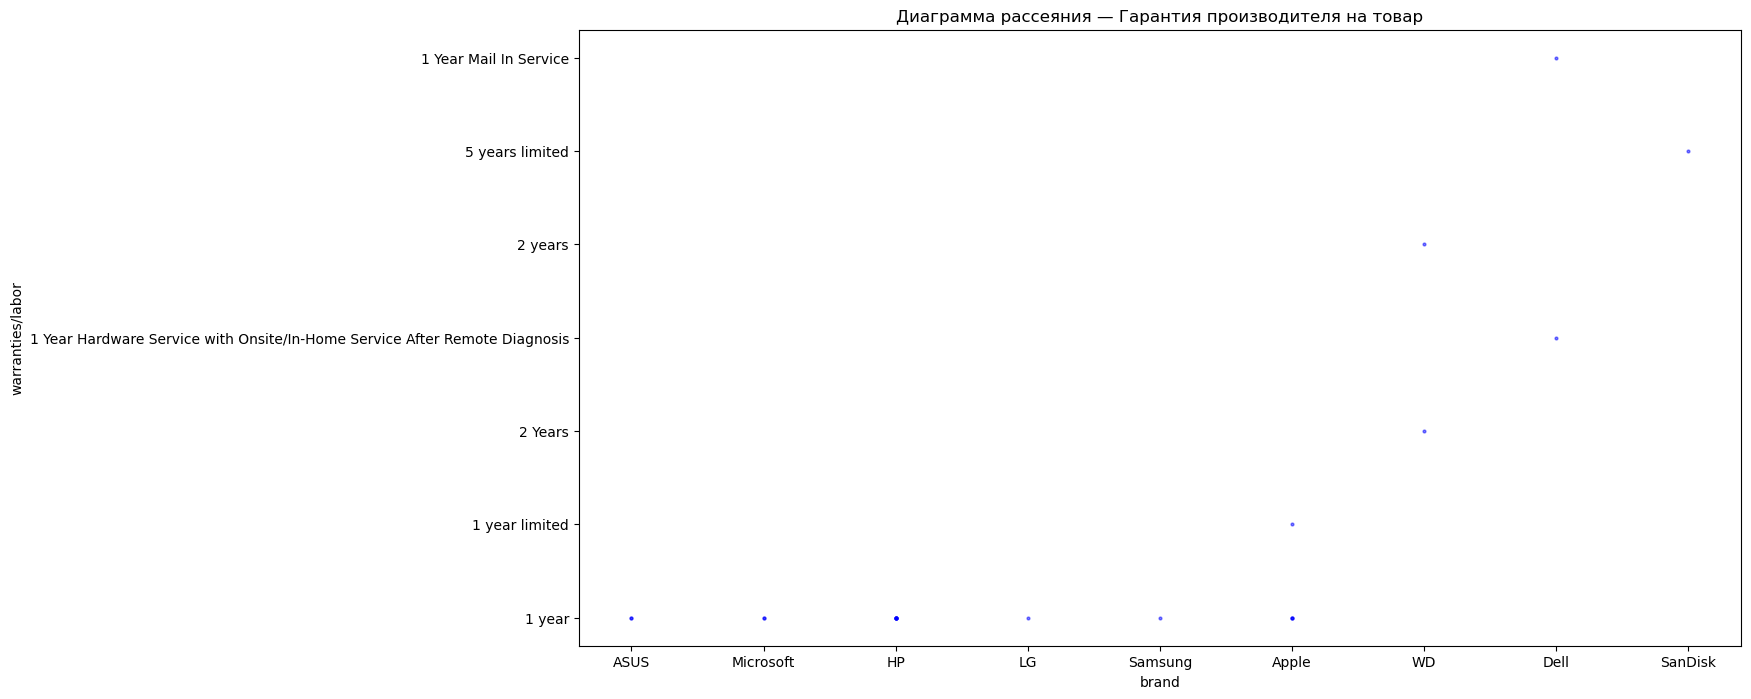

In [34]:
data.plot(kind='scatter',
        y='warranties/labor' , x='brand', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Гарантия производителя на товар');

Самую продолжительную гарантию предоставляет бренд SanDisk - 5 лет гарантии. WD предоставляет гарантию 2 года на одну из моделей. В среднем производитель предлагает 1 год гарантии. Это самый распространненый срок гарантии.

Отобразим распределение ноутбуков по весу на гистограмме.

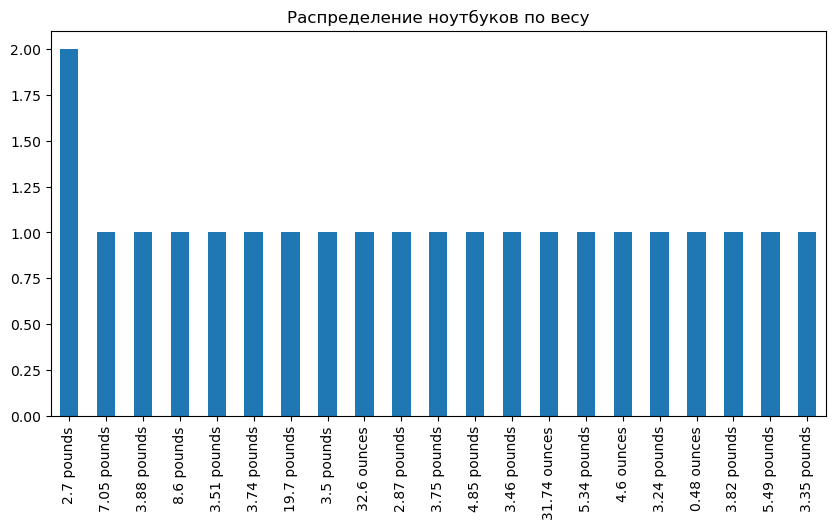

In [35]:
data['weight'].value_counts().sort_values(ascending=False).plot(figsize=(10,5),kind="bar",title='Распределение ноутбуков по весу');

Все ноутбуки весят по разному. Самое популярное значение - 2.7 фунта. Такой вес представлен у двух моделей. Также стоит отметить,что вес представлен в двух значениях - pounds(фунт) и ounces(унция). 

Построим аналогичную диаграмму для столбца width.

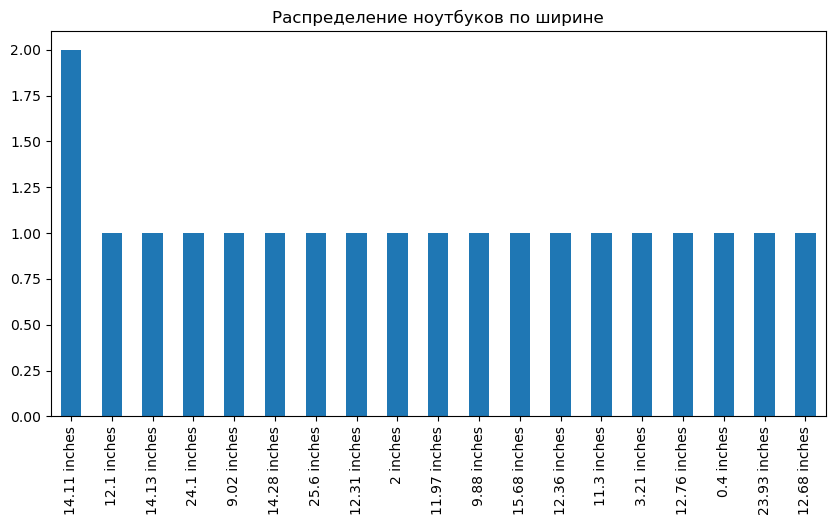

In [36]:
data['width'].value_counts().sort_values(ascending=False).plot(figsize=(10,5),kind="bar",title='Распределение ноутбуков по ширине');

Аналогичная ситуация как и на предыдущем графике. Распределение ноутбуков по ширине разнообразно. 14.11 дюйма самое популярное значение встречается у двух моделей. 

## Вывод по проекту.

**Технические особенности получения данных:**

- Данные получены через стороний сервис blog.apify.com. В качестве источниках данных был выбран сайт bestbuy.com, раздел laptop-and-computer-deals;  
- Полученные данные выгружены в качестве ссылки и csv файла;    
- В результате предобработки данных датасет был проверен на дубликаты, пропуски. Для строк с пропусками было принято решение не заполнять их, так как заполнение средним или медианными значениями могут исказить результаты исследований. А проверенными данными мы не обладаем. Также были выборочно удалены столбцы не содержащие основную информацию о товаре;  

**Основные тезисы сформулированные в процессе исследования данных:**
- Два самых популярных бренда в текущем датасете. Это HP и Apple;
- Cамый дорогой бренд - это Apple (цена начинается от 1000 долларов). Два самых недорогих бренда: Asus(200 долларов) и LG(менее 200 долларов). В нашем датасете самый широкий разброс цен у бренда HP(цены варьируются от 200 до 1000);
- Два самых популярных цвета - серебрянный и черный. Наименее популярные цвета - серый, зеленый, космический серый и синий;
- Большинство устройств с достаточном высоким рейтингом(от 4.5 до 4.75) по оценке пользователей;
- Больше всего устройств высотой 0.71 дюйма - 3 модели;
- Все товары представлен в валюте USD;
- Самую продолжительную гарантию предоставляет бренд SanDisk - 5 лет гарантии. WD предоставляет гарантию 2 года на одну из моделей. В среднем производитель предлагает 1 год гарантии. Это самый распространненый срок гарантии;
- Все ноутбуки весят по разному. Самое популярное значение - 2.7 фунта. Такой вес представлен у двух моделей. Также стоит отметить,что вес представлен в двух значениях - pounds(фунт) и ounces(унция).